In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


## 1.Identify point sources downstream of monitoring points

Find point sources downstream of water chemistry sampling points on the "main" rivers.

In [4]:
# Period of interest
st_yr, end_yr = 2017, 2019

# Point sources to consider. Aquaculture is negligible in vassoms 001 to 017
sectors = ["large wastewater", "industry"]

# TEOTIL pars
pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "toc", "ss"]

# Standard TEOTIL3 result file (NOT the baseline file for the OsloMod project)
teo_csv = r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2024_2013-2023_agri-annual-loss.csv"

# Regines used by Leah for chem monitoring sites
xl_path = r"../data/leah_oslomod_main_rivs.xlsx"

In [5]:
# Read Leah's data for vassoms 001 to 017
loc_df = pd.read_excel(xl_path)
loc_df

,id,name,lat,lon,regine,vassom
0,6,Tista,59.119,11.370,001.A1,1
1,7,Glomma,59.206,10.953,002.A51,2
2,8,Mosseelva,59.439,10.662,003.A1,3
3,9,Hølenelva,59.523,10.690,004.A0,4
4,10,Årungen,59.720,10.728,005.3A,5
5,11,Akerselva,59.908,10.756,006.A10,6
6,12,Lysakerelva,59.914,10.640,007.A0,7
7,13,Sandvikselva,59.890,10.523,008.A11,8
8,14,Åros,59.704,10.519,009.A0,9
9,15,Tofteelva,59.547,10.568,010.2Z,10


In [6]:
# Get regine spatial data and build network graph
reg_gdf = teo.io.get_regine_geodataframe(eng, 2023)
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

100.00 % of regines assigned.


In [7]:
# Single polygon for whole Oslofjord catchment
reg_gdf["vassom_int"] = reg_gdf["vassom"].astype(int)
osl_gdf = reg_gdf.query("1 <= vassom_int <= 17").copy()
osl_gdf["dissolve"] = 1
osl_gdf = osl_gdf.dissolve(by="dissolve")

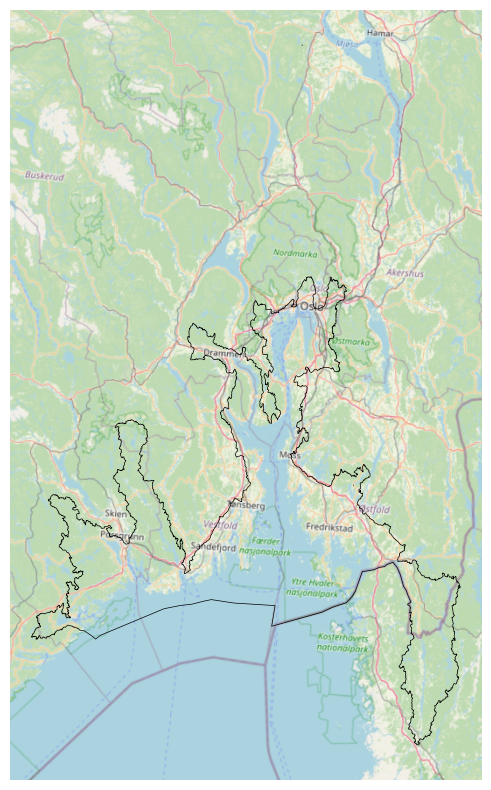

In [8]:
# Get polys upstream of each monitoring point
gdf_list = []
for idx, row in loc_df.iterrows():
    site_name = row["name"]
    reg_id = row["regine"]
    gdf, ax = teo.vis.plot_catchment(
        g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
    )
    plt.close()
    gdf["name"] = site_name
    gdf = gdf[["regine", "name", "geometry"]]

    gdf_list.append(gdf)
gdf = pd.concat(gdf_list, axis="rows")

# Merge monitored catchments to a single poly
upstr_gdf = gdf.copy()
upstr_gdf["dissolve"] = 1
upstr_gdf = upstr_gdf.dissolve(by="dissolve")

# Subtract from whole Oslofjord catchment to get downstream part
downstr_gdf = osl_gdf.overlay(upstr_gdf, how="difference")

# Plot downstream catchment
ax = downstr_gdf.plot(color="none", edgecolor="black", figsize=(10,10))
cx.add_basemap(
    ax,
    crs=downstr_gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)
ax.axis('off');

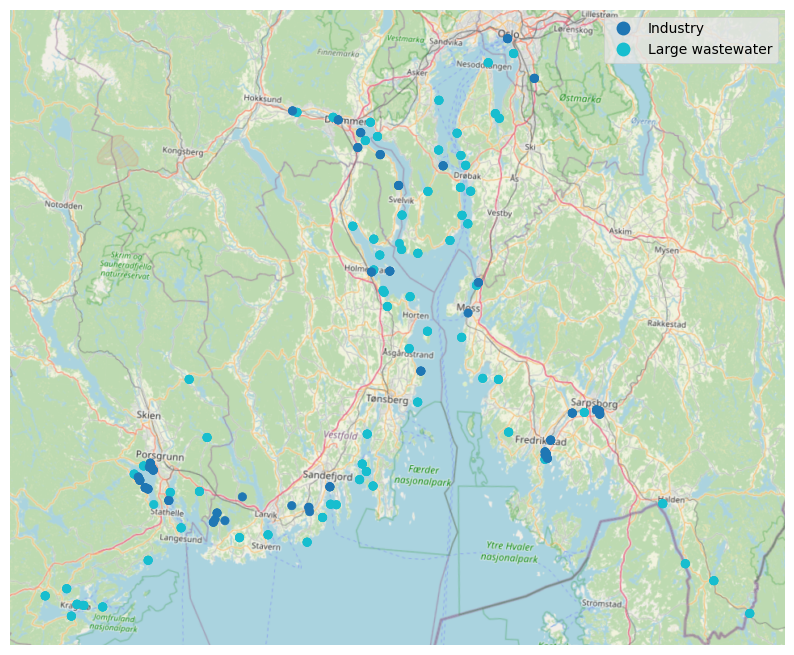

In [9]:
# Get point sources from TEOTIL database 
df_list = []
for year in range(st_yr, end_yr + 1):
    for sector in sectors:
        pt_df = teo.io.get_raw_annual_point_data(
            eng,
            year,
            sector,
            par_list=[
                "totn_kg",
                "din_kg",
                "ton_kg",
                "totp_kg",
                "tdp_kg",
                "tpp_kg",
                "toc_kg",
                "ss_kg",
            ],
        )
        df_list.append(pt_df)

pt_df = pd.concat(df_list, axis="rows")

# Build point source gdf
pt_gdf = gpd.GeoDataFrame(
    pt_df,
    geometry=gpd.points_from_xy(pt_df["outlet_x_utm33"], pt_df["outlet_y_utm33"]),
    crs="epsg:25833",
)

# Get point sources within the downstream area
downstr_pt_gdf = gpd.sjoin(
    pt_gdf, downstr_gdf[["vassom", "geometry"]], predicate="within"
)
downstr_pt_gdf = downstr_pt_gdf[pt_gdf.columns]

# Plot
ax = downstr_pt_gdf.plot(column="sector", legend=True, figsize=(10, 10))
# downstr_gdf.plot(ax=ax, color="none", edgecolor="black")
cx.add_basemap(
    ax,
    crs=downstr_gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)
ax.axis("off");

In [10]:
downstr_pt_gdf.drop(columns="geometry").to_excel(
    r"../data/downstream_point_sources.xlsx", index=False
)
downstr_pt_gdf.head()

,site_id,site_name,sector,type,site_x_utm33,site_y_utm33,outlet_x_utm33,outlet_y_utm33,year,regine,DIN_kg,SS_kg,TDP_kg,TOC_kg,TON_kg,TOTN_kg,TOTP_kg,TPP_kg,geometry
0,0301.0979.01,Bekkelaget renseanlegg med tilførselstuneller ...,Large wastewater,Kjemisk-biologisk m/N-fjerning,263347.073035,6.646048e+06,262704.276918,6.645807e+06,2017,006.21,302806.1,375794.5,6193.5,343369.7,95623.0,398429.1,13763.3,7569.8,POINT (262704.277 6645806.588)
863,3101.0051.01,Prestebakke,Large wastewater,Biologisk,301383.130803,6.543874e+06,301405.296531,6.543897e+06,2017,001.1A2B,1150.9,1286.2,76.9,5510.8,172.0,1322.9,174.7,97.8,POINT (301405.297 6543897.407)
864,3101.0052.01,Bakke (Nedlagt),Large wastewater,Kjemisk-biologisk,295950.748421,6.547185e+06,295895.605980,6.547175e+06,2017,001.2220,757.4,13487.7,4.4,9665.2,84.2,841.5,34.0,29.6,POINT (295895.606 6547175.329)
865,3101.0054.01,Kornsjø,Large wastewater,Kjemisk-biologisk,308388.496555,6.537612e+06,308347.248183,6.537567e+06,2017,001.1J,595.7,1715.7,6.0,1186.7,66.2,661.9,46.5,40.5,POINT (308347.248 6537566.641)
866,3101.0055.01,Remmendalen avløpsanlegg,Large wastewater,Kjemisk-biologisk,291726.785370,6.559128e+06,291532.153379,6.558785e+06,2017,001.310,77382.2,115444.9,204.9,76209.8,8598.0,85980.2,1576.4,1371.5,POINT (291532.153 6558784.914)


In [16]:
id_cols = ['site_id', 'site_name', 'sector']
par_cols = [col for col in downstr_pt_gdf.columns if col.endswith('_kg')]
avg_downstr_pt_gdf = downstr_pt_gdf[id_cols + par_cols]
avg_downstr_pt_gdf = avg_downstr_pt_gdf.groupby(id_cols).mean().reset_index().sort_values('TOTN_kg', ascending=False)

avg_downstr_pt_gdf.to_excel(
    r"../data/downstream_point_sources_avg-2017-19.xlsx", index=False
)
avg_downstr_pt_gdf.head()

,site_id,site_name,sector,DIN_kg,SS_kg,TDP_kg,TOC_kg,TON_kg,TOTN_kg,TOTP_kg,TPP_kg
32,3203.0059.01,Sentralrenseanlegg Vest (VEAS),Large wastewater,818938.333333,1.538428e+06,13605.400000,1.556252e+06,258612.066667,1.077550e+06,30234.200000,16628.800000
70,3806.0039.01,Yara Porsgrunn,Industry,608333.333333,NaN,2533.333333,NaN,NaN,6.083333e+05,5066.666667,2533.333333
28,3107.0134.01,Øra avløpsanlegg,Large wastewater,327492.233333,4.280301e+05,727.900000,5.795479e+05,127358.100000,4.548503e+05,5599.300000,4871.400000
1,0301.0979.01,Bekkelaget renseanlegg med tilførselstuneller ...,Large wastewater,307847.300000,3.779305e+05,6790.633333,4.103854e+05,97214.933333,4.050622e+05,15090.266667,8299.633333
87,3905.0110.01,Tønsberg renseanlegg,Large wastewater,292109.366667,1.724729e+05,508.966667,2.864527e+05,32456.633333,3.245660e+05,3915.166667,3406.200000


## 2. Compare TEOTIL3 to OF800 inputs for chemistry monitoring stations

In [11]:
teo_df = pd.read_csv(teo_csv).query("@st_yr <= year <= @end_yr")

cols = [col for col in teo_df.columns if col.startswith("accum_")]
teo_df = teo_df[["regine", "year"] + cols]

for par in pars:
    par_cols = [col for col in teo_df.columns if f"_{par}_" in col]
    teo_df[f"{par.upper()}_tonnes"] = teo_df[par_cols].sum(axis="columns") / 1000
    teo_df = teo_df.drop(columns=par_cols)

teo_df = pd.merge(loc_df, teo_df, how="inner", on="regine")

val_cols = [col for col in teo_df.columns if col.endswith("_tonnes")]
id_cols = ["name", "year"]
teo_comp_df = teo_df[val_cols + id_cols].melt(
    id_vars=id_cols, value_name="TEOTIL3", var_name="par"
)
teo_comp_df.head()

,name,year,par,TEOTIL3
0,Tista,2017,TOTN_tonnes,569.734970
1,Tista,2018,TOTN_tonnes,769.324566
2,Tista,2019,TOTN_tonnes,797.245840
3,Glomma,2017,TOTN_tonnes,13675.306333
4,Glomma,2018,TOTN_tonnes,18366.648350


**To do.**